# **Resfinder Visualizations**

### ***Objectives for this notebook***
- Utilize Resfinder to evaluate AMR resistances within bacteria strains
- Use data to visualize and plot patterns beyond what Resfinder shows
- Use **only** for one strain

# Formatting Instructions

To use this program, you must download and rename the files as instructed.

1) Open [Resfinder](http://genepi.food.dtu.dk/resfinder)
2) Adjust parameters if necessary, upload FASTA file where it says "Upload and print job". Once you are done, click "Submit job"
3) Scroll down to downloads and click "Download phenotypetable (txt)", renaming the file as "phenotypetable.txt".
4) Below at **"Download acquired AMR gene results:"**, click "Results as text" and rename the file to "amrresults.txt".
5) Run code!

# Evaluating Phenotype Results
*Note: Remember that file should be in .txt format and properly named as "phenotypetable.txt"*

### Data Preparation

In [76]:
import pandas as pd

file_path = "phenotypetable.txt"

# Reads the file, skipping comments and blank lines
df_phenotype = pd.read_csv(
    file_path,
    sep="\t",
    comment="#",
    skip_blank_lines=True,
    names=[
        "Antimicrobial", "Class", "WGS_predicted_phenotype", "Match", "Genetic_background"
    ]
)

# Additional cleanup
df_phenotype = df_phenotype.map(lambda x: x.strip() if isinstance(x, str) else x)
df_phenotype["Match"] = pd.to_numeric(df_phenotype["Match"], errors="coerce")
    # resistant = 1; nonresistant = 0
df_phenotype["Resistant"] = df_phenotype["WGS_predicted_phenotype"].apply(lambda x: 0 if "No resistance" in str(x) else 1)
df_phenotype = df_phenotype.sort_values(by="Resistant", ascending=False)

# Check dataframe
df_phenotype.head(5)

,Antimicrobial,Class,WGS_predicted_phenotype,Match,Genetic_background,Resistant
37,imipenem,beta-lactam,Resistant,3,mecA (mecA_BX571856),1
36,ertapenem,beta-lactam,Resistant,3,mecA (mecA_BX571856),1
35,ceftazidime,beta-lactam,Resistant,3,mecA (mecA_BX571856),1
34,cefoxitin,beta-lactam,Resistant,3,mecA (mecA_BX571856),1
85,mupirocin,pseudomonic acid,Resistant,3,mupA (mupA_GU237136),1


### Visualizations

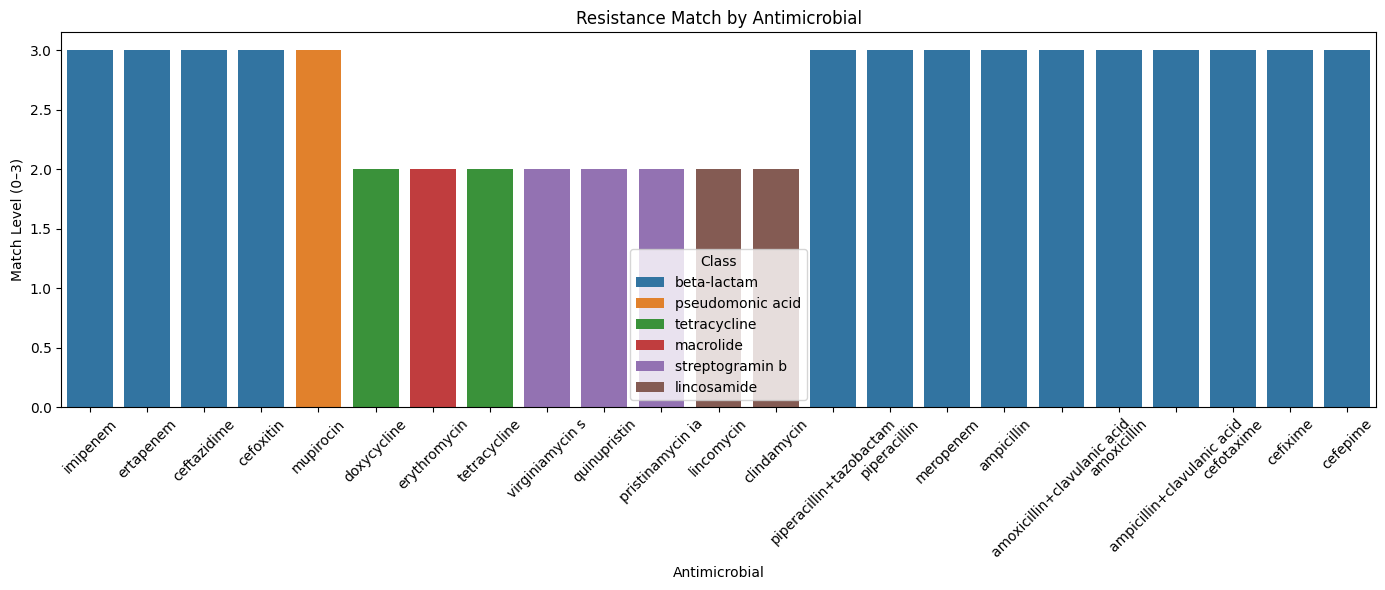

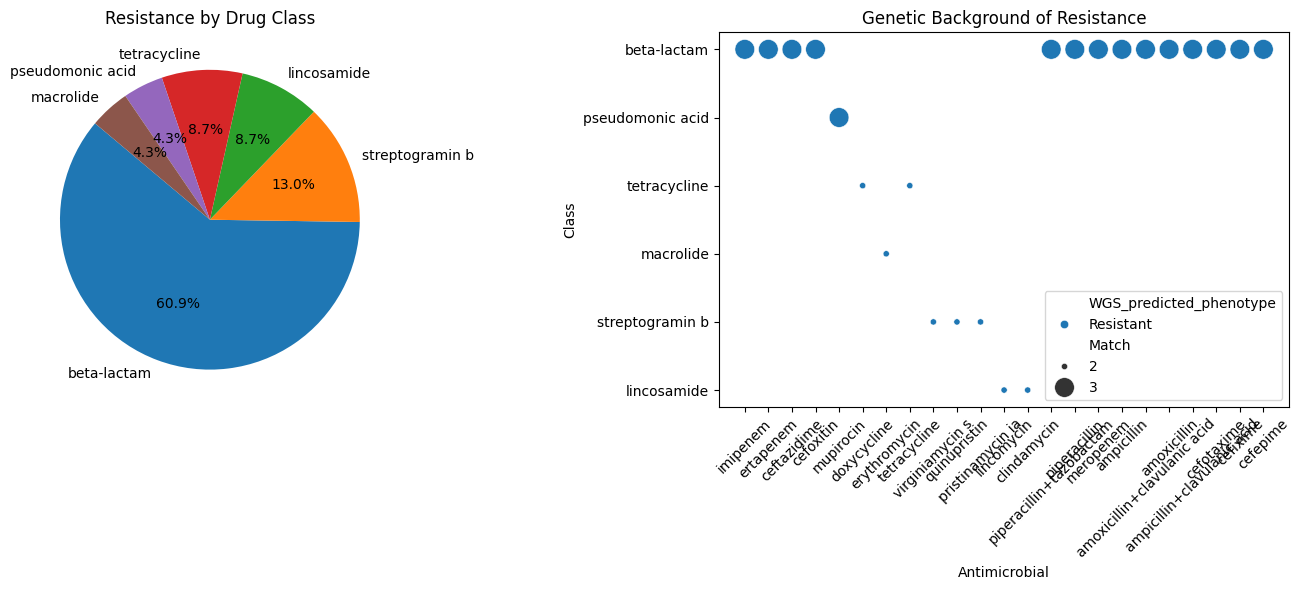

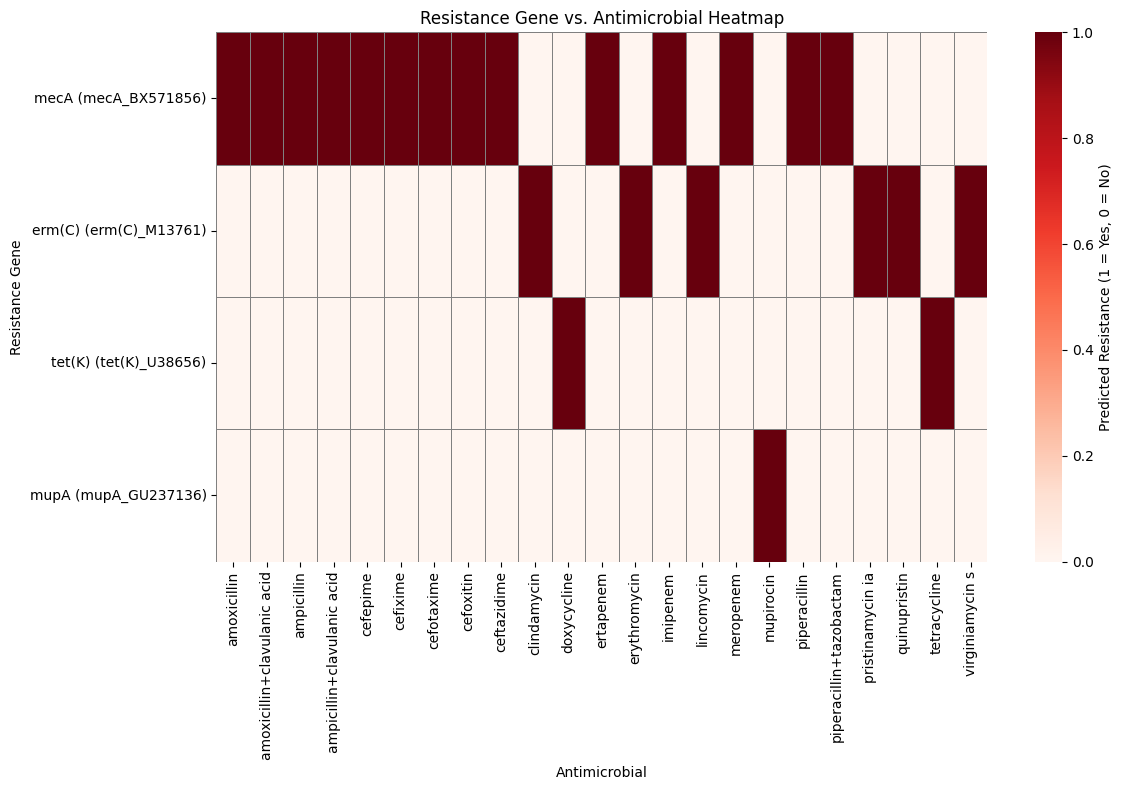

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

fig1, ax1 = plt.subplots(figsize=(14, 6))

# Filter to only rows showing resistance (by prediction or match level)
df_resphenotype = df_phenotype[
    (df_phenotype["WGS_predicted_phenotype"] != "No resistance") |
    (df_phenotype["Match"] > 0)
]


# 1. Bar chart (resistance per antimicrobial)
sns.barplot(
    data=df_resphenotype,
    x="Antimicrobial",
    y="Match",
    hue="Class",
    dodge=False,
    ax=ax1
)

ax1.set_title("Resistance Match by Antimicrobial")
ax1.set_ylabel("Match Level (0–3)")
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Second figure: Pie + Scatter
fig2, axs = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart: resistance by drug class
class_counts = df_resphenotype["Class"].value_counts()
axs[0].pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=140)
axs[0].set_title("Resistance by Drug Class")

# Scatter plot: genetic background vs antimicrobial
sns.scatterplot(
    data=df_resphenotype,
    x="Antimicrobial",
    y="Class",
    size="Match",
    hue="WGS_predicted_phenotype",
    ax=axs[1],
    sizes=(20, 200)
)

axs[1].set_title("Genetic Background of Resistance")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# -------------------------------
# 3. Heatmap: Resistance gene vs. Antimicrobial
heatmap_data = df_phenotype.pivot_table(
    index="Genetic_background",
    columns="Antimicrobial",
    values="Resistant",
    fill_value=0
)

# Optional: sort for visual clarity
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
heatmap_data = heatmap_data[heatmap_data.sum(axis=0).sort_values(ascending=False).index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="Reds",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Predicted Resistance (1 = Yes, 0 = No)"}
)
plt.title("Resistance Gene vs. Antimicrobial Heatmap")
plt.xlabel("Antimicrobial")
plt.ylabel("Resistance Gene")
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Filter and clean
sankey_df = df_resphenotype[["Genetic_background", "WGS_predicted_phenotype", "Antimicrobial"]].dropna()
sankey_df["Gene"] = sankey_df["Genetic_background"].str.split(";;").str[0]
sankey_df["Full_Phenotype"] = (sankey_df["Antimicrobial"].str.capitalize())

# Group and count gene -> phenotype links
grouped = sankey_df.groupby(["Gene", "Full_Phenotype"]).size().reset_index(name="Count")

# Create labels
labels = pd.unique(grouped[["Gene", "Full_Phenotype"]].values.ravel())
label_indices = {label: idx for idx, label in enumerate(labels)}
sources = grouped["Gene"].map(label_indices)
targets = grouped["Full_Phenotype"].map(label_indices)
values = grouped["Count"]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(title_text="Gene to Phenotype Sankey Diagram", font_size=10)
fig.show()
